# Fourier Analysis for a reduced genomics dataset   
Memebers: R. Garza, L. González, S. Nwakanma  
We are reducing the dataset when we have both copies of a mutation not just one ore both (instead of an or, its now an and)

# Dependancies

In [14]:
import numpy as np
import pandas as pd 
from scipy import special
import scipy.sparse #import dok_matrix
# import scipy.sparse.linalg
import types
from itertools import combinations
import pylab as plt
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import csv
import os
os.mkdir("plots-and")
os.mkdir("plots2-and")

# Dataset (and)

In [2]:
gene_dat = pd.read_csv('vcf_FA.csv',index_col='Unnamed: 0',encoding='utf-8')
matrix = gene_dat.as_matrix()
gene_mut = np.zeros((matrix.shape[0],int(np.ceil((matrix.shape[1])/2))))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [3]:
# will go through each row (# of observations)
for rows in range(matrix.shape[0]):
    for cols in range(0,matrix.shape[1]-1,2):
        # within those observations, it will go until the 
        # 2nd to last column (excludes phenotype)
        # checks to see if either the L or R gene has a mutation
        if(matrix[rows][cols]==1 and matrix[rows][cols+1]==1):
            # if it does, then in the copied matrix, 
            # a 1 will be input
            gene_mut[rows][int(cols/2)]=1
            #reason for int(cols/2) is to match up 
            #indexes with the pairing # that it's on
            #ex: 0&1 gene output val. will be in the 
            # 0 index of copied matrix 2&3 gene output 
            # val. will be in the 1 index, 4*6 in the 
            # 2nd index

In [4]:
# gets last column from original matrix, puts it as last column for copied matrix
gene_mut[:,-1]=matrix[:,-1] 

In [5]:
gene_mut

array([[   1.,    0.,    1., ...,    0.,    0.,  196.],
       [   1.,    1.,    1., ...,    0.,    0.,  173.],
       [   1.,    0.,    0., ...,    0.,    0.,  198.],
       ..., 
       [   1.,    0.,    1., ...,    0.,    0.,  168.],
       [   1.,    0.,    0., ...,    0.,    0.,  155.],
       [   1.,    0.,    1., ...,    0.,    0.,  145.]])

# Spectral Analysis

In [6]:
# input: matrix
# output: list
# Takes in a matrix and returns a list that contains the numbers 
# of zeros on each line of the matrix correspondingly
def num_of_mutations(RDM):
    # make copy of data to not alter 
    tempRDM = np.copy(RDM)
    tempRDM = np.delete(tempRDM,-1,1)
    # list to count the number of ones
    nones = []
    nrows = RDM.shape[0]
    # for each row, sum the rows and save in list of ones
    for row in range(nrows):
        nones.append(sum(tempRDM[row,]))
    # create list of zeros by subracting the total amount of 
    # columns by the ones
    nzeros = [tempRDM.shape[1]]*(len(nones))
    nzeros = [a_i - b_i for a_i, b_i in zip(nzeros, nones)]
    # return list of ceros
    return nzeros

# input: matrix, list
# output: list of matrices
# Takes in a matrix and divides it into smalles matrices that 
# have the same amount of zeron in each line
def raw_data_partitions(RDM, nzeros):
    nrows = RDM.shape[0]
    ncols = RDM.shape[1]
    # variable to store matrices
    fPartitions = []
    # get unique values of the amount of zeros 
    distinct_amounts_zeros = np.unique(nzeros)
    distinct_amounts_zeros = np.sort(distinct_amounts_zeros)
    # for each amount of zeros
    for amount in distinct_amounts_zeros:
        list_amount_i = []
        # check every row if compatible with amount of zeros
        for row in range(nrows):
            if(nzeros[row]==amount):
                # and store them
                list_amount_i.append(RDM[row,])
        # to concatenate into a matrix
        Matrix_amount_i = np.concatenate(list_amount_i).reshape(len(list_amount_i), ncols)
        # and append it to the list of smaller matrices
        fPartitions.append((amount, Matrix_amount_i))
    # return list of smaller matrices
    return fPartitions

# input: list of tuples of float and matrix
# output: two lists of tuples of float and matrix
# Takes in a list of tuples that contain k 
# and data matrix with k zeros in each row and 
# separates them into two lists one with majority 
# zeros the other with minority zeros
def MinoritiesMajorities(dataPartition):
    Minorities = []
    Majorieties = []
    nvars = dataPartition[0][1].shape[1] - 1
    limit = np.floor(nvars/2)
    for elem in range(len(dataPartition)):
        k = dataPartition[elem][0]
        if (k > limit):
            Majorieties.append(dataPartition[elem])
        else:
            Minorities.append(dataPartition[elem])
    return Minorities, Majorieties

# input: one dimensional matrix (horizontal)
# output: tuple or int
# Takes in a row and categorizes the row by the amount of zeros 
# and returns the corresponding variables to the zeros 
# e.g. the row [1,0,1,0] with the columns 1234, return (2,4)
# e.g. the row [0,1,1,1] with columns 1234 returns 1
def categorize_row(row):
    # copy row to not alter the data
    tempRow = np.copy(row)
    tempRow = np.asarray(tempRow)
    # length of row without including the last column (which are the results)
    length = len(tempRow)-1 # minus hemoglobin
    # variable to store the variables corresponding to the zeros
    category = []
    # check line for zeros
    for i in range(length):
        if(int(tempRow[i]) == 0):
            category.append(i)
    # if it is only one zero in the row it returns the int
    if(len(category) != 1):
        # returns tuple of category
        return tuple(category)
    else:
        return category[0]
    
# input: tuple of int and matrix
# output: array
# Takes in a tuple of the number of zeros in the matrix and 
# the matrix and calculates f^(n, n-#0s)
def calc_f(PartitionTuple):
    # save all the variables
    k = PartitionTuple[0]
    data = PartitionTuple[1]
    nrows = data.shape[0]
    nvars = data.shape[1]-1
    # list to append the categories to
    rowCategory = []
    # for individual values the row categories are calculated
    # differently because we dont have to use the function 
    # combinations for the lexicographical order
    if(k == 1):
        # counter to know how many hemoglobin we add so we can average them
        counter = np.zeros(int(nvars))
        f = np.zeros(int(nvars))
        lexOrder = list(range(int(nvars)))
    else:
        # counter to know how many hemoglobin we add so we can average them
        counter = np.zeros(int(special.binom(nvars,nvars-int(k))))
        f = np.zeros(int(special.binom(nvars,nvars-int(k))))
        lexOrder = list(combinations(list(range(nvars)),int(k)))
    # for every row in the matrix add a category for each line
    # to rowCategory list
    for row in range(nrows):
        cat = categorize_row(data[row,])
        rowCategory.append(cat)
    # for every row in the data
    for row in range(nrows):
        # go through all the orgers
        for order in range(len(lexOrder)):
            # and check if the categories match
            if(rowCategory[row] == lexOrder[order]):
                # add one to the counter
                counter[order] = counter[order] + 1
                # if they do, add the results (hemoglobin) to the data vector
                f[order] = f[order] + data[row,-1]    
    # divide data vector by the counter to average it
    averagef = np.zeros(len(f))
    # be sure not to divide by zero
    for i in range(len(averagef)):
        if(int(counter[i]) == 0):
            averagef[i] = f[i]
        else:
            averagef[i] = f[i]/counter[i]
    # return data vector
    return averagef, counter

# input: tuple of int and matrix
# output: list of arrays
# Caluclates f^(n, n-k) for all ks and returns them 
# in a list of data vectors
def create_data_vectors(PartitionList):
    dataVectors = []
    counterVectors = []
    for data in range(len(PartitionList)):
        datavec, counter = calc_f(PartitionList[data])
        dataVectors.append(datavec)
        counterVectors.append(counter)
    return dataVectors, counterVectors

# input: string or list, int
# output: list of tuples
# This function returns all the combination of the characters in the string 
# of length k as a list of tuples. It can also take a list as its first 
# argument and has the same output but treats the elements of the list 
# like characters in a string. It should be noted that this function
# "renames" the function combinations of the itertools library
# so it is more readable to the user.
def alphabet_choose_k(alphabet, k):
    return list(combinations(alphabet, int(k)))

# input: list of same length tuples
# output: matrix
# Takes in a tuple list each of the same size k which are all the 
# combinations of our variables and calculates the adjacency matrix
# of its Johnson Graph 
def calc_adj_mat(tuple_list):
    # type check the tuple list
    if isinstance(tuple_list, list)==False:
        return("Argument is not a list!")
    # Create adjacency matrix of size of the amount of tuples in the 
    # list on both columns and rows
    dim = len(tuple_list)  
    # SparseAdj = dok_matrix((dim,dim))
    Adj = np.zeros((dim,dim))
    # Go through the matrix 
    for i in range(dim):
        for j in range(dim):
            # if the intersection of the nodes (which are the tuples) 
            # is equal to their length - 1 then they are connected
            # and we put a one in the matrix to represent that connection
            if len(set(tuple_list[i]).intersection(set(tuple_list[j]))) == len(tuple_list[0])-1:
                # SparseAdj[i,j] = 1
                Adj[i,j] = 1
    return Adj

# input: matrix
# output: list of floats, list of arrays
# Takes in an adjacency matrix (which is symmetric) and calculates
# the eigen values and eigen vectors and returns them as a list of floats
# and as a list of arrays respectively. It should be noted that the 
# eigen values corrspond with the same indexed eigen vectors.
# This function "renames" the function np.linalg.eigh for the
# purpose of making it easier for the user.
def calc_eig_vec_of_adj_matrix(mat):
    eig_val, eig_vec = np.linalg.eigh(mat)
    return eig_val, eig_vec

# input: list of floats
# output: list of arrays
# Since the eigen vectors corresponding to the same M_i in a 
# given decomposition (n,k) have the same eigen value, this
# function (that takes in eigen vectors and eigen values in 
# order of correspondance) concatenates (as matrices) eigen 
# vectors that correspond to the same M_i and returns these 
# as a list of matricies that are the basis for the M_i's
# in ascending order (i.e. [M_0, M_1,...,M_k])
def group_eig_vecs(e_vals, e_vecs):
    # gather the distinct eigen values and sort them
    distinct_vals = np.unique(e_vals.round(decimals=4))
    distinct_vals = np.sort(distinct_vals)
    # create empty list where we will store the basis
    M_basis = []
    # for every distinct eigen value we will go through the 
    # list of eigen values and if they are equal we will add the
    # corresponding eigen vector to a list 
    for val in distinct_vals:
        # list for storing eigen vectors that correspond to 
        # the same M_i
        vec_list = []
        for i in range(len(e_vals)):
            if(val == e_vals[i].round(decimals=4)):
                vec_list.append(np.transpose(e_vecs)[i])
        # transform list of arrays into matrix to append to M basis list
        vec_list = np.array(vec_list).reshape(len(vec_list), len(vec_list[0]))
        M_basis.append(vec_list)
    # return M basis
    M_basis = np.flipud(M_basis)
    return M_basis

# input: array, list of matrices
# output: list of arrays
# This functions calculates the projection of the data vector 
# f onto each of the M_i basis (in the form of a matrix)
def proj_f_onto_M(f, M_basis):
    # emptylist to store the f_is as we calculate them 
    f_is = []
    # for every element of the list of M basis we will 
    # calculate f_i and append it to the list
    for i in range(len(M_basis)):
        f_is.append(proj_onto_M_i(f, M_basis[i]))
    # return list of f_i's
    return f_is

# input: array, matrix
# output: array
# This function takes in a data vector and a basis for M_i and 
# projects f onto that basis to calculate f_i
def proj_onto_M_i(f, M_i):
    # get the dimensions of M_i
    nrow = M_i.shape[0]
    ncol = M_i.shape[1]
    # create a zero vector to add the projections calculated by
    # components in the eigen vectors 
    f_i = np.zeros(ncol)
    # for each row of the basis (recall we saved the eigen vectors
    # as lines) we calculare the projections
    for j in range(nrow):
        # temporarily reshape the row to transform it from an array
        # to a one dimentional matrix (vertical)
        tmp = np.copy(M_i[j])
        tmp = tmp.reshape(len(M_i[j]),1)
        # add the new projection to f_i
        f_i = f_i + project(f, tmp)
    # return f_i
    return f_i
    
# input: one dimentional matrix, array
# output: one dimentional matrix
# This funtion calculates the projection of f onto b
def project(f, v):
    # reshape v to be a one dimentional matrix compatible 
    # for dot (or inner) product (horizontal)
    v = v.reshape(1,len(v))
    # calculate projection and return it
    result = (np.dot(v,f)/np.dot(v,np.transpose(v)))*v
    return result

# input: list (of ints or strings) or string, list, tuple
# output: list of arrays
# Takes in a list of data vectos given a partition (n,k)
# k being the amount of zeros in a row, implements Mallow's
# method and returns a list of data vectors as arrays
def Mallows_list(alphabet, f_iList, partition):
    # partition = (n,k)
    k = partition[1]
    # first data vector f_0 does nor change 
    # so we append it intact
    MallowsList = [np.concatenate(f_iList[0])]
    # for every data vecto f_i, 0<i<k-1, implement 
    # Mallows method
    for f_iIndex in range(1,k):
        MallowsList.append(calc_Mallow(alphabet, f_iList[f_iIndex], f_iIndex, k))
    # last data vecto f_k does not change so we append it
    # without changes
    MallowsList.append(np.concatenate(f_iList[-1]))
    # return mallows list
    return MallowsList

# input: list (of ints or strings) or string, array, int
# output: array
# Takes in a data vector f_i and returns Mallow's f_i
def calc_Mallow(alphabet, f_i, i, k):
    # variables
    rows = list(combinations(alphabet, i))
    cols = alphabet_choose_k(alphabet, k)
    # zero array for storing values
    Mallow_f_i = np.zeros(len(rows))
    # T matrix just sums the values of the data vector 
    # where the values of (n choose i) (rows) is a subset
    # of the partition (n choose k) (columns)
    for iElem in range(len(rows)):
        for kElem in range(len(cols)):
            if(set(rows[iElem]).issubset(set(cols[kElem]))):
                # add elements of the data vector to 
                # Mallows data vector
                Mallow_f_i[iElem] = Mallow_f_i[iElem] + f_i[0,kElem]
    # return Maloow's data vector
    return Mallow_f_i

# Main function  
## Zeros in the minority

In [7]:
# store raw data as a copy
Raw_Data = np.copy(gene_mut)

# count number of zeros on each row
num_zeros = num_of_mutations(Raw_Data)

# count the numebr of variables
num_vars = Raw_Data.shape[1]-1

# partition data by amount of zeros (list of matrices)
Sub_Data = raw_data_partitions(Raw_Data, num_zeros)

# capture just the data where 0 is in the minority
Min_Sub_Data, Maj_Sub_Data = MinoritiesMajorities(Sub_Data)

# create list of data vectors (data vector partitioned)
# i.e. data vector contains individuals, pairs, triples, etc
# we will partition the data vector into a list of arrays
# containing individual data vector, pairs data vector, etc
data_vectors_f, counter_vectors = create_data_vectors(Min_Sub_Data)

# save the k that are in the minorities
zero_minorities = []
for i in range(len(Min_Sub_Data)):
    zero_minorities.append(Min_Sub_Data[i][0])
    
# create list to contain Mallow Vectors and 
# their corresponding n-k amount of mutations
AllMallowVectors = []

# for every partition (n,k) data vector we want to calculate
# the decomposition: f = f_0 + f_1 + ... + f_k
for kindex in range(len(zero_minorities)):
    
    # partition data vector
    f = data_vectors_f[kindex]
    k = zero_minorities[kindex]
    
    # create tuples for k pairings
    variable_tuples = alphabet_choose_k(list(range(num_vars)), k)
    
    # calculate adjacency matrix and its eigen values 
    Adjacency = calc_adj_mat(variable_tuples)
    
    # calculate eigenvalues and eigenvectors of Adjacency Matrix
    eig_vals, eig_vecs = calc_eig_vec_of_adj_matrix(Adjacency)
    
    # create M basis to project data vector onto
    M_basis = group_eig_vecs(eig_vals, eig_vecs)
    
    # capture correct data vector to project
    f = data_vectors_f[kindex].reshape(len(data_vectors_f[kindex]),1)
    
    # project f onto M basis
    f_list = proj_f_onto_M(f, M_basis)
    
    # Use Mallows method to transform f_is into interpretable vectors
    MalList = Mallows_list(list(range(num_vars)), f_list, (num_vars,int(k)))
    
    # Append to list of all Mallow data vectors
    AllMallowVectors.append( (num_vars-k,MalList) )

In [8]:
for i in range(len(AllMallowVectors)):
    print(AllMallowVectors[i][0])

8.0
7.0


## Ones in the minorities  
We currently have saved all Mallow vectors for when zero is in the minority (i.e. when we have 10,9,8,7 mutations). Now we need to analyze when zeros are in the majority (i.e. when we have 5 and 6 mutations).

An option is to just flip all the data set, but it would be more costly computation wise, so we can flip the matrices in the list $Maj\_Sub\_Data$ and run the same calculations there. 

In [9]:
# input: list of tuples of length two (float, matrix)
# output: list of tuples of length two (float, matrix)
# This function takes in a list of tuples where the 
# first value is the amount of zeros on each row (denoted k) of the 
# matrix (second value of tuple) and it flips the matricies
# i.e. changes all the 1's to 0's and vice versa
# it also changes the k to the total amount of variables 
# (denoted n) minus k (so it does keep count of the amount of zeros)
def flipMajorities(Majority_Data):
    New_Minorities = []
    for tupIndex in range(len(Majority_Data)):
        k = Majority_Data[tupIndex][0]
        data = Majority_Data[tupIndex][1]
        ncols = data.shape[1]-1
        nrows = data.shape[0]
        newMatrix = np.zeros((nrows, ncols+1))
        for i in range(nrows):
            for j in range(ncols):
                if(int(data[i,j]) == 1):
                    newMatrix[i,j] = 0
                elif(int(data[i,j]) == 0):
                    newMatrix[i,j] = 1
        # copy hemoglobin as is
        for h in range(nrows):
            newMatrix[h, -1] = data[h, -1]
        New_Minorities.append( (ncols-k, newMatrix) )
    return New_Minorities

In [10]:
New_Min_Data = flipMajorities(Maj_Sub_Data)

In [11]:
# create list of data vectors (data vector partitioned)
# i.e. data vector contains individuals, pairs, triples, etc
# we will partition the data vector into a list of arrays
# containing individual data vector, pairs data vector, etc
data_vectors_f2, counter_vectors2 = create_data_vectors(New_Min_Data)

# save the k that are in the minorities
zero_minorities2 = []
for i in range(len(New_Min_Data)):
    zero_minorities2.append(New_Min_Data[i][0])
    
# create list to contain Mallow Vectors and 
# their corresponding n-k amount of mutations
AllMallowVectors2 = []

# for every partition (n,k) data vector we want to calculate
# the decomposition: f = f_0 + f_1 + ... + f_k
for kindex2 in range(len(zero_minorities2)):
    
    # partition data vector
    f2 = data_vectors_f2[kindex2]
    k2 = zero_minorities2[kindex2]
    
    # create tuples for k pairings
    variable_tuples = alphabet_choose_k(list(range(num_vars)), k2)
    
    # calculate adjacency matrix and its eigen values 
    Adjacency = calc_adj_mat(variable_tuples)
    
    # calculate eigenvalues and eigenvectors of Adjacency Matrix
    eig_vals, eig_vecs = calc_eig_vec_of_adj_matrix(Adjacency)
    
    # create M basis to project data vector onto
    M_basis = group_eig_vecs(eig_vals, eig_vecs)
    
    # capture correct data vector to project
    f = data_vectors_f2[kindex2].reshape(len(data_vectors_f2[kindex2]),1)
    
    # project f onto M basis
    f_list = proj_f_onto_M(f, M_basis)
    
    # Use Mallows method to transform f_is into interpretable vectors
    MalList = Mallows_list(list(range(num_vars)), f_list, (num_vars,int(k2)))
    
    # Append to list of all Mallow data vectors
    AllMallowVectors2.append( (k2,MalList) )

In [12]:
for i in range(len(AllMallowVectors2)):
    print(AllMallowVectors2[i][0])

6.0
5.0
4.0
3.0
2.0
1.0


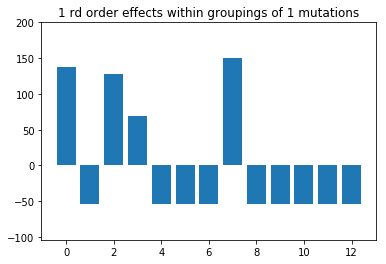

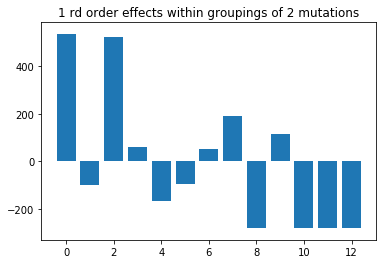

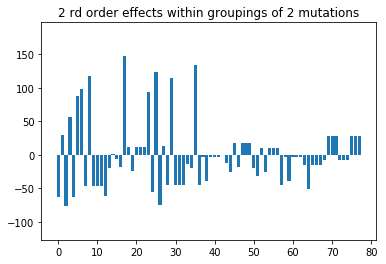

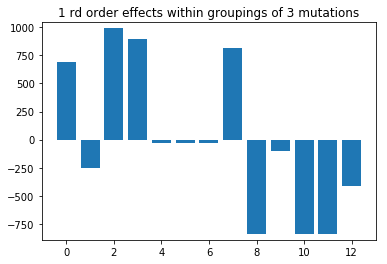

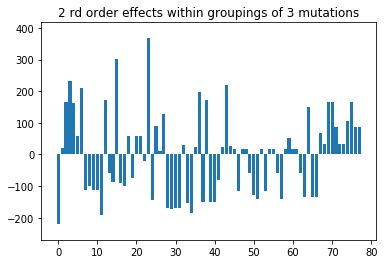

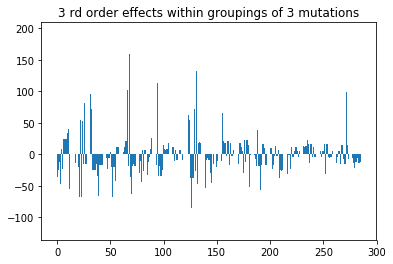

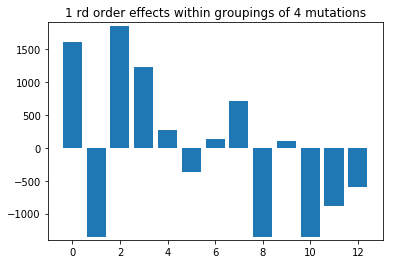

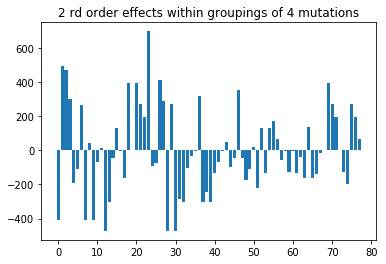

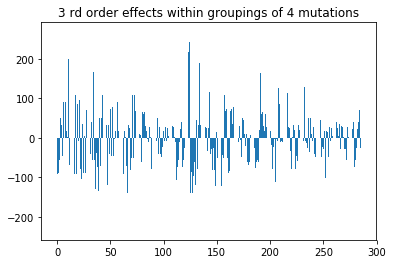

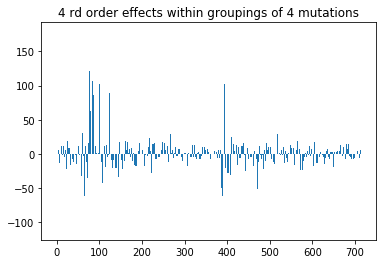

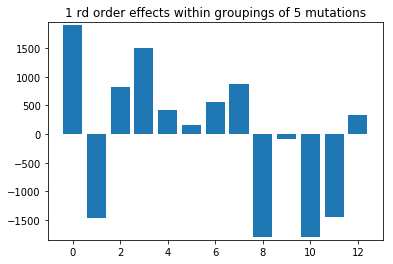

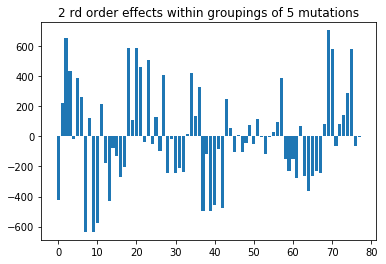

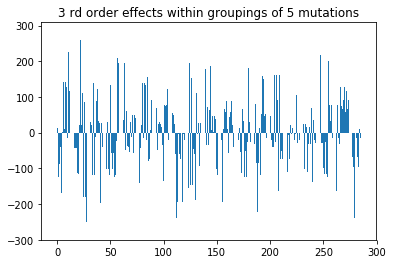

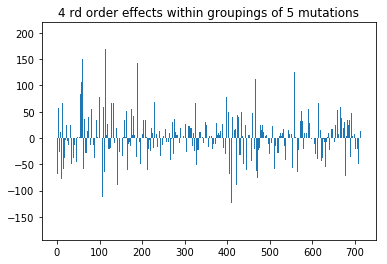

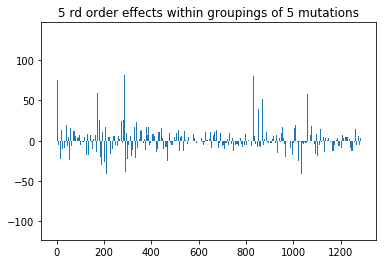

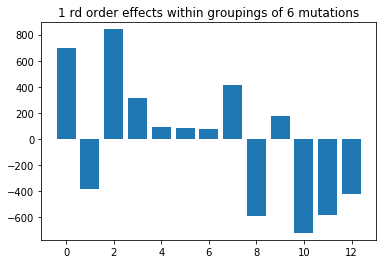

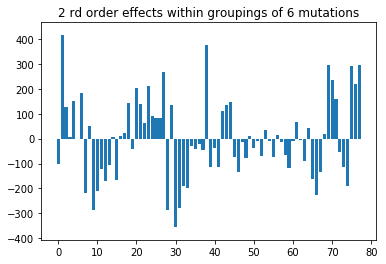

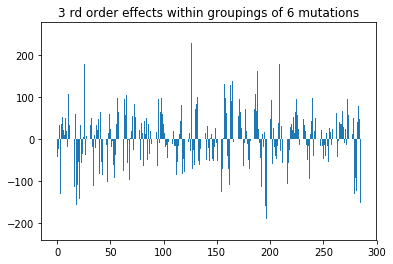

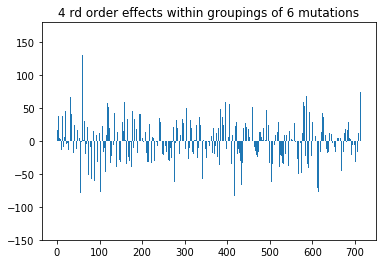

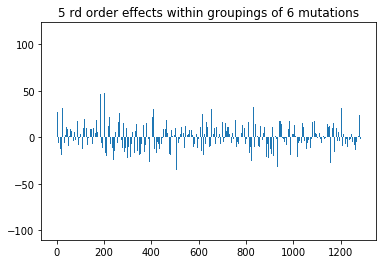

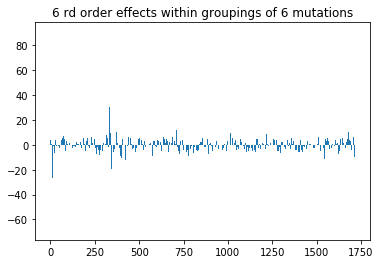

In [15]:
for nmut in range(len(AllMallowVectors2)-1,-1,-1):
    k = AllMallowVectors2[nmut][0]
    MallowList = AllMallowVectors2[nmut][1]
    for order in range(1,len(MallowList)):
        y_axis = np.arange(len(MallowList[order]))
        plt.bar(y_axis, MallowList[order], align='center')
        plt.title('%d rd order effects within groupings of %d mutations'%(order, k))
        plt.ylim((min(MallowList[order])-50),(max(MallowList[order])+50))
        plt.savefig("plots-and/%d_order_13_%d.png"%(order,k))
        plt.show()

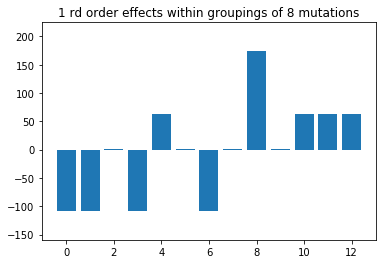

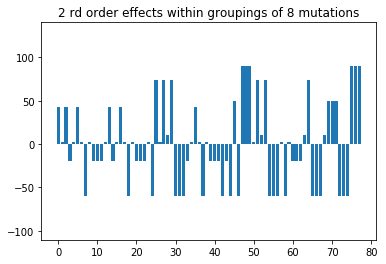

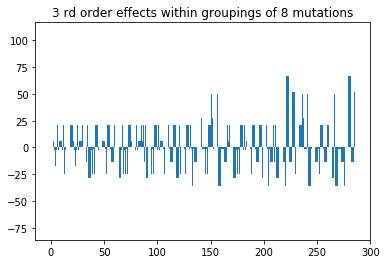

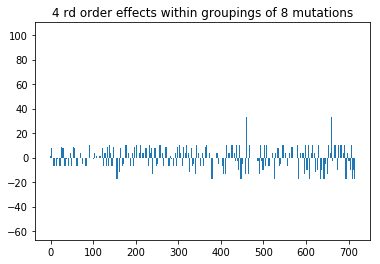

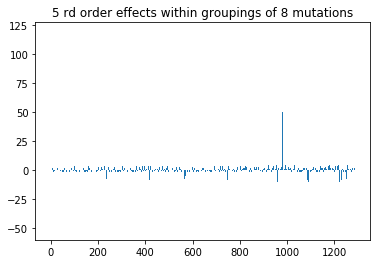

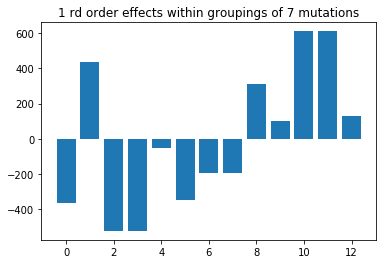

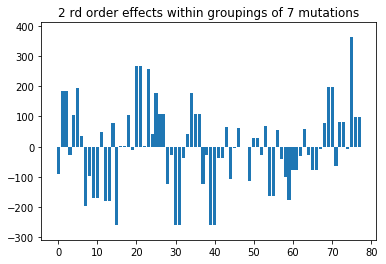

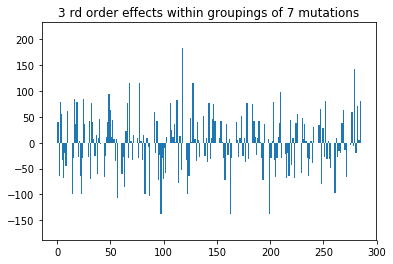

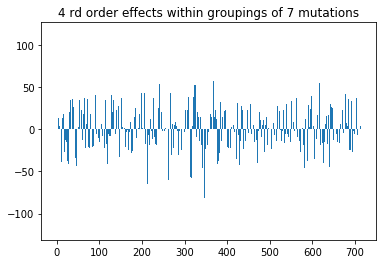

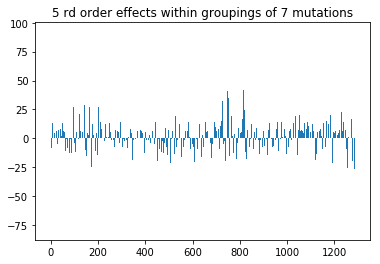

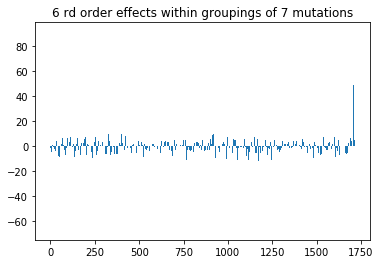

In [17]:
for nmut in range(len(AllMallowVectors)):
    k = AllMallowVectors[nmut][0]
    MallowList = AllMallowVectors[nmut][1]
    for order in range(1,len(MallowList)):
        y_axis = np.arange(len(MallowList[order]))
        plt.bar(y_axis, MallowList[order], align='center')
        plt.title('%d rd order effects within groupings of %d mutations'%(order, k))
        plt.ylim((min(MallowList[order])-50),(max(MallowList[order])+50))
        plt.savefig("plots2-and/%d_order_13_%d.png"%(order,k))
        plt.show()